<a href="https://colab.research.google.com/github/FaiyazKhan11/CSE476-Handwritten-Character-Recognition/blob/master/Handwritten_Character_Recognition_(2016331011).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Necessary Libraries

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.utils import shuffle
from keras.layers.convolutional import MaxPooling2D
import keras

## Downloading the data 

In [ ]:
!gdown --id 1FqdnKFvc_s5h6Xw0Sng7zcp4VKglCkzb

Downloading...
From: https://drive.google.com/uc?id=1FqdnKFvc_s5h6Xw0Sng7zcp4VKglCkzb
To: /content/A_Z Handwritten Data.csv
699MB [00:08, 87.1MB/s]


In [ ]:
data = pd.read_csv("/content/A_Z Handwritten Data.csv").astype('float32')

X = data.drop('0',axis = 1)
y = data['0']

In [ ]:
print(len(X))

372450


## Exploratory Data Analysis (EDA)

In [ ]:
# Reshaping the data in csv file so that it can be displayed as an image...

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2)
train_x = np.reshape(train_x.values, (train_x.shape[0], 28,28))
test_x = np.reshape(test_x.values, (test_x.shape[0], 28,28))

In [ ]:
print("Train data shape: ", train_x.shape)
print("Test data shape: ", test_x.shape)

Train data shape:  (297960, 28, 28)
Test data shape:  (74490, 28, 28)


In [ ]:
# Dictionary for getting characters from index values...
word_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X', 24:'Y',25:'Z'}

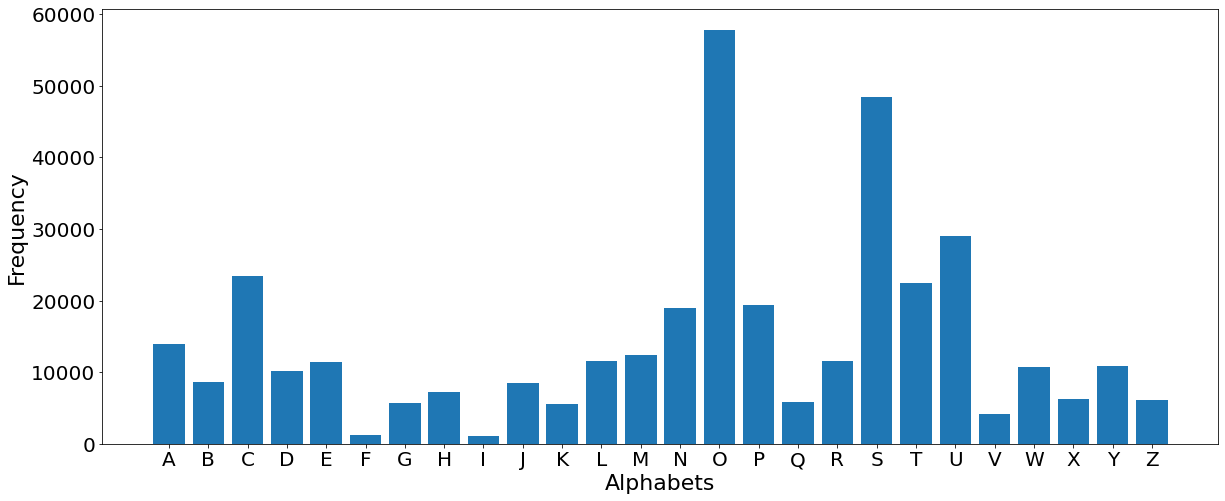

In [ ]:
# Plotting the number of alphabets in the dataset...
plt.rcParams.update({'font.size': 20})
train_yint = np.int0(y)
count = np.zeros(26, dtype='int')
for i in train_yint:
    count[i] +=1

alphabets = []
for i in word_dict.values():
    alphabets.append(i)

fig, ax = plt.subplots(1,1, figsize=(20,8))
ax.bar(alphabets, count)

plt.xlabel("Alphabets", fontsize = 22)
plt.ylabel("Frequency", fontsize = 22)
plt.show()

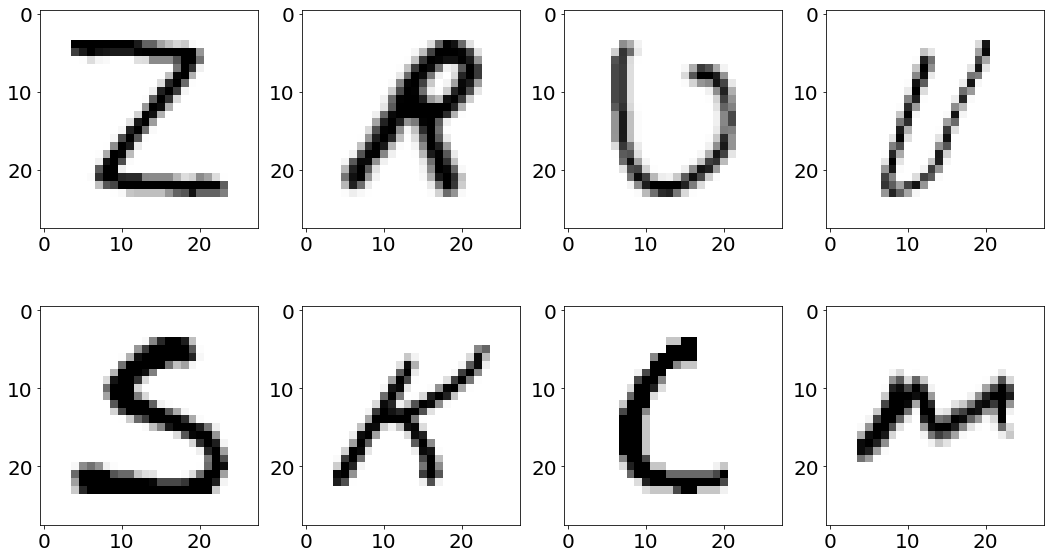

In [ ]:
#Shuffling the data ...
shuff = shuffle(train_x[:100])

fig, ax = plt.subplots(2,4, figsize = (18,10))
axes = ax.flatten()

for i in range(8):
    axes[i].imshow(np.reshape(shuff[i], (28,28)), cmap="Greys")
plt.show()

## Basic Machine Learning Models

In [ ]:
import itertools

def display_conf_mat(model, X, y):
    _, ax = plt.subplots(figsize=(20, 20))
    plot_confusion_matrix(model, X, y, 
                          display_labels=np.array(english_alphabet[0]).astype(str),
                          cmap=plt.cm.Blues, ax=ax)
    plt.show()
    

def custom_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(14, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
english_dataset = np.array(pd.read_csv('/content/A_Z Handwritten Data.csv'))

In [ ]:
english_alphabet = pd.DataFrame(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
                                 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
                                'u', 'v', 'w', 'x', 'y', 'z'], [i for i in range(1, 27)])
english_alphabet

In [ ]:
X, y = english_dataset[:, 1:], english_dataset[:, 0]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X.shape, y.shape

((372450, 784), (372450,))

In [ ]:
#Preprocessing the image for input

from sklearn.base import BaseEstimator, TransformerMixin

class ImageTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, width=14, height=14,  is_img=False):
        self.width = width
        self.height = height
        self.is_img = is_img
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.is_img:
            images = []
            # load the image and convert to grayscale
            for img in X:                
                
                image = img.convert('L').resize((self.width, self.height))
                
                enhancer = ImageEnhance.Contrast(image)
                image = enhancer.enhance(1.0)
                
                images.append(np.asarray(image).reshape(-1))
            return np.array(images)
        else:
            return X

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler


preprocessing_pipeline = Pipeline([
    ('image_trf', ImageTransformer()),
    ('scaler', StandardScaler()),
])

width, height = 28, 28
preprocessing_pipeline.set_params(image_trf__width=width, image_trf__height=height, image_trf__is_img=False)
X_train_proc = preprocessing_pipeline.fit_transform(X_train)
X_test = preprocessing_pipeline.transform(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.metrics import accuracy_score, plot_confusion_matrix

## Logistic Regression|

In [ ]:
from sklearn.linear_model import LogisticRegression

scores = cross_val_score(LogisticRegression(max_iter=1000), X_train_proc[:2000], y_train[:2000], cv=5)
scores.mean()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7935000000000001

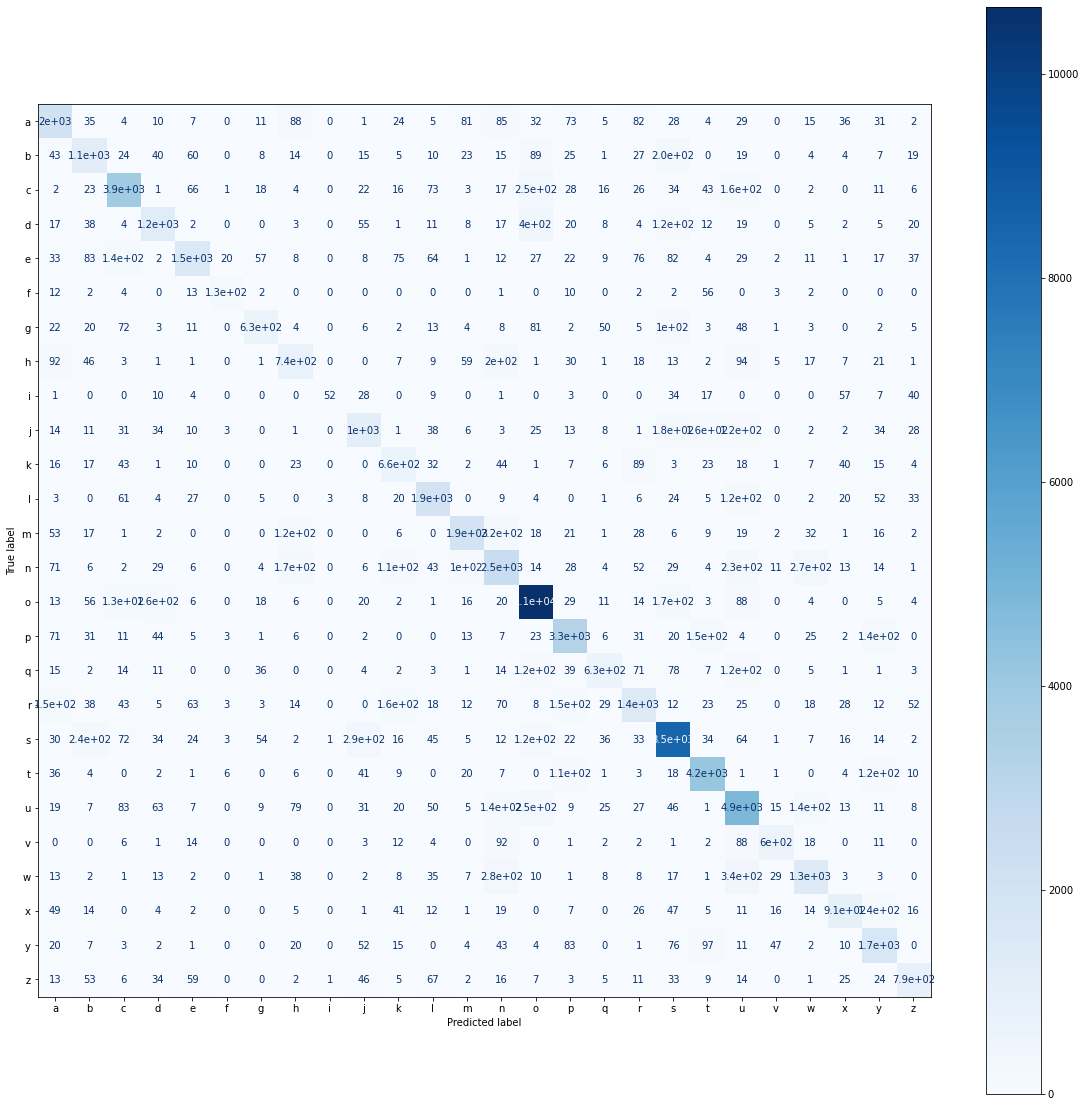

In [ ]:
log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train_proc[:2000], y_train[:2000])
display_conf_mat(log_clf, X_test, y_test)

In [ ]:
lr_pred = log_clf.predict(X_test)
accuracy_score(lr_pred, y_test)

0.7795274533494428

## Support Vector Classifier

In [ ]:
from sklearn.svm import SVC

scores = cross_val_score(SVC(), X_train_proc[:2000], y_train[:2000], cv=5)
scores.mean()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.781

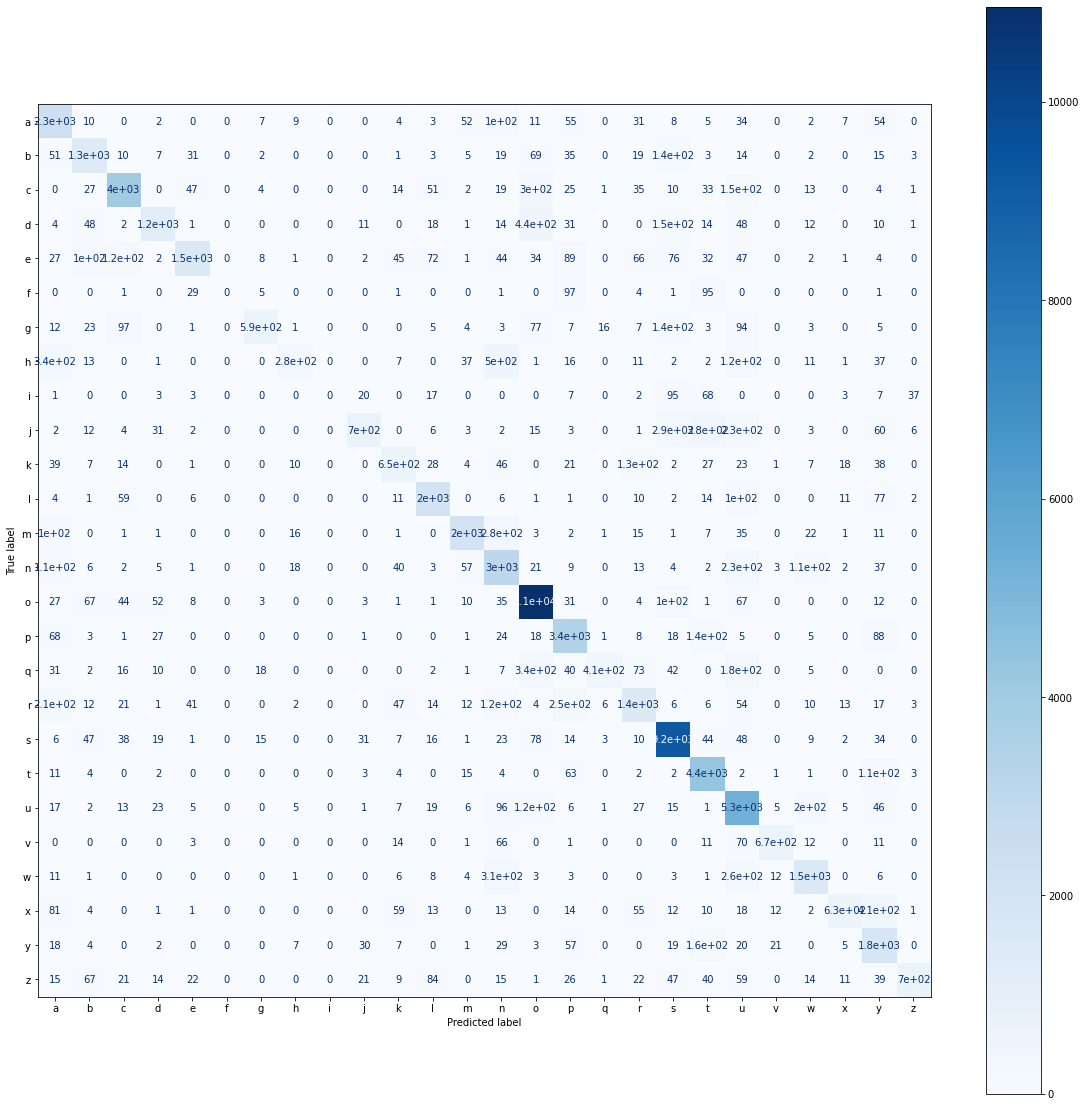

In [ ]:
svc_clf = SVC()
svc_clf.fit(X_train_proc[:2000], y_train[:2000])
display_conf_mat(svc_clf, X_test, y_test)

In [ ]:
svc_pred_forest = svc_clf.predict(X_test)
accuracy_score(svc_pred_forest, y_test)

0.8065780641696872

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(max_depth=10)

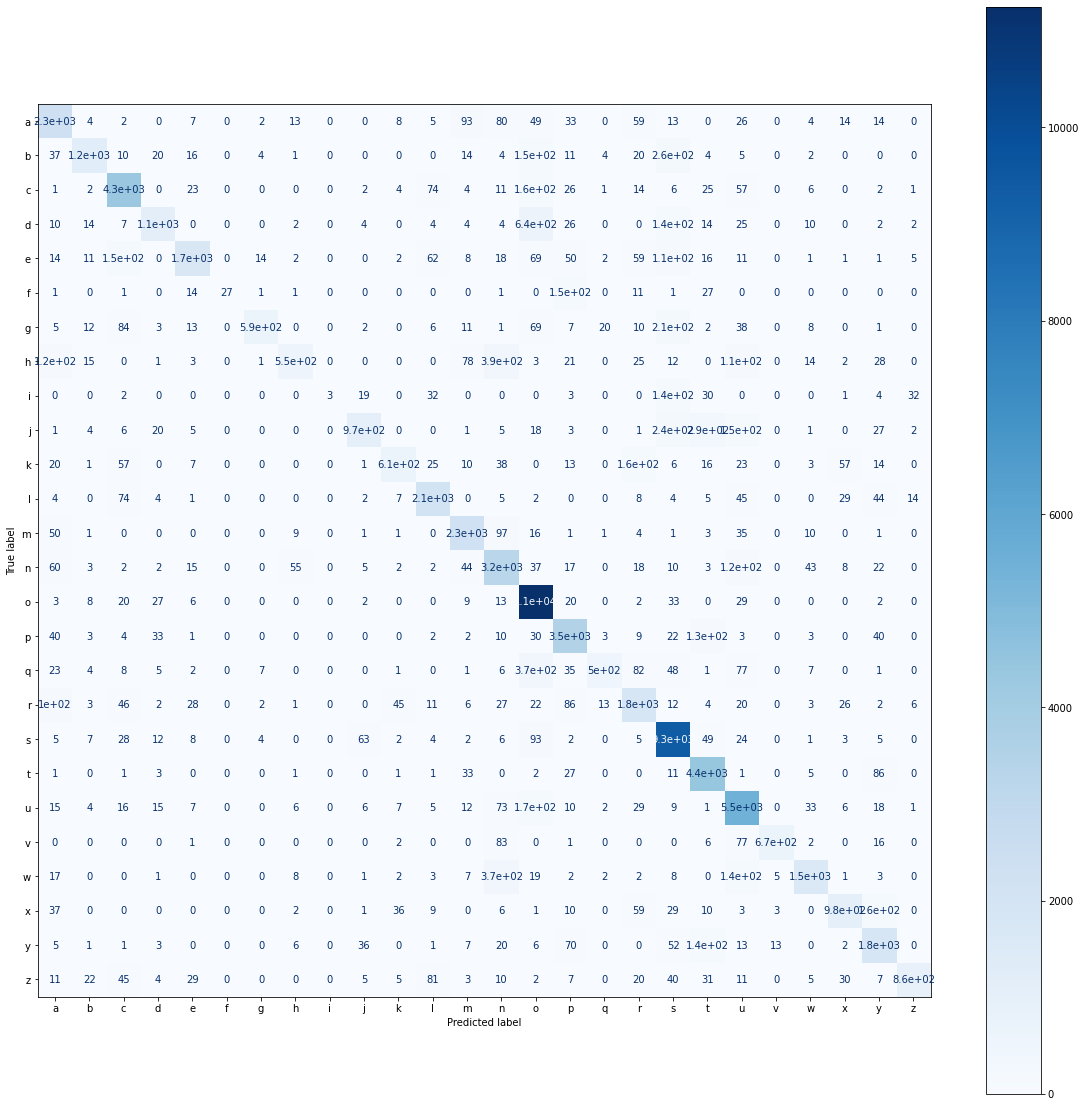

In [ ]:

forest_clf.fit(X_train_proc[:5000], y_train[:5000])
display_conf_mat(forest_clf, X_test, y_test)

In [ ]:
y_pred_forest = forest_clf.predict(X_test)
accuracy_score(y_pred_forest, y_test)

0.8473217881594844

In [ ]:
scores = cross_val_score(RandomForestClassifier(max_depth=10), X_train_proc[:2000], y_train[:2000], cv=5)
scores.mean()

0.7785

## Deep Learning Based Models

In [ ]:
#Reshaping the training & test dataset so that it can be put in the model...

train_X = train_x.reshape(train_x.shape[0],train_x.shape[1],train_x.shape[2],1)
print("New shape of train data: ", train_X.shape)

test_X = test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2],1)
print("New shape of train data: ", test_X.shape)

New shape of train data:  (297960, 28, 28, 1)
New shape of train data:  (74490, 28, 28, 1)


In [ ]:
# Converting the labels to categorical values...

train_yOHE = to_categorical(train_y, num_classes = 26, dtype='int')
print("New shape of train labels: ", train_yOHE.shape)

test_yOHE = to_categorical(test_y, num_classes = 26, dtype='int')
print("New shape of test labels: ", test_yOHE.shape)

New shape of train labels:  (297960, 26)
New shape of test labels:  (74490, 26)


## Model 01

In [ ]:
# Model 01

model1 = Sequential()

model1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model1.add(MaxPool2D(pool_size=(2, 2), strides=2))

model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model1.add(MaxPool2D(pool_size=(2, 2), strides=2))

model1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model1.add(MaxPool2D(pool_size=(2, 2), strides=2))

model1.add(Flatten())

model1.add(Dense(64,activation ="relu"))
model1.add(Dense(128,activation ="relu"))

model1.add(Dense(26,activation ="softmax"))

In [ ]:
model1.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

In [ ]:
history1 = model1.fit(train_X, train_yOHE, epochs=20, callbacks=[reduce_lr, early_stop],  validation_data = (test_X,test_yOHE), batch_size=128)

Epoch 1/20
2328/2328 [==============================] - 16s 6ms/step - loss: 0.6139 - accuracy: 0.8713 - val_loss: 0.0691 - val_accuracy: 0.9809
Epoch 2/20
2328/2328 [==============================] - 15s 6ms/step - loss: 0.0683 - accuracy: 0.9804 - val_loss: 0.0573 - val_accuracy: 0.9836
Epoch 3/20
2328/2328 [==============================] - 14s 6ms/step - loss: 0.0524 - accuracy: 0.9847 - val_loss: 0.0557 - val_accuracy: 0.9840
Epoch 4/20
2328/2328 [==============================] - 15s 6ms/step - loss: 0.0442 - accuracy: 0.9871 - val_loss: 0.0434 - val_accuracy: 0.9880
Epoch 5/20
2328/2328 [==============================] - 15s 6ms/step - loss: 0.0362 - accuracy: 0.9895 - val_loss: 0.0440 - val_accuracy: 0.9889
Epoch 6/20
2328/2328 [==============================] - 15s 6ms/step - loss: 0.0163 - accuracy: 0.9953 - val_loss: 0.0240 - val_accuracy: 0.9943
Epoch 7/20
2328/2328 [==============================] - 15s 6ms/step - loss: 0.0072 - accuracy: 0.9981 - val_loss: 0.0220 - val_ac

In [ ]:
model1.summary()
model1.save(r'model_hcr_1.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)              

In [ ]:
# Displaying the accuracies & losses for train & validation set...

print("The validation accuracy is :", history1.history['val_accuracy'])
print("The training accuracy is :", history1.history['accuracy'])
print("The validation loss is :", history1.history['val_loss'])
print("The training loss is :", history1.history['loss'])

The validation accuracy is : [0.980923593044281, 0.9835548400878906, 0.9839575886726379, 0.9879849553108215, 0.9889246821403503, 0.9942811131477356, 0.9946838617324829, 0.995730996131897, 0.995274543762207, 0.9967915415763855, 0.996898889541626, 0.9964962005615234, 0.9969525933265686, 0.9966707229614258, 0.9969391822814941]
The training accuracy is : [0.9469761252403259, 0.9812122583389282, 0.985004723072052, 0.9870553016662598, 0.988951563835144, 0.9960665702819824, 0.9979527592658997, 0.9985702633857727, 0.9990804195404053, 0.9997650980949402, 0.9999094009399414, 0.9999160766601562, 0.9998959302902222, 0.9999395608901978, 0.9999328851699829]
The validation loss is : [0.06908506900072098, 0.05732468515634537, 0.0557108074426651, 0.043376680463552475, 0.04400600120425224, 0.023960452526807785, 0.0220163706690073, 0.021736513823270798, 0.02341853640973568, 0.020473333075642586, 0.022609610110521317, 0.02545766532421112, 0.023883730173110962, 0.025276433676481247, 0.025961700826883316]
T

In [ ]:
test_acc = history1.history['val_accuracy'][history1.history['val_loss'].index(min(history1.history['val_loss']))]
print("Accuracy on the test for Model1 data: ", test_acc)

Accuracy on the test for Model1 data:  0.9967915415763855


#Model 2

In [ ]:
# Model 02
model2 = Sequential()
model2.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(26, activation='softmax'))

In [ ]:
model2.compile(optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

In [ ]:
history2 = model2.fit(train_X, train_yOHE, epochs=20, callbacks=[reduce_lr, early_stop],  validation_data = (test_X,test_yOHE), batch_size=128)

Epoch 1/20
2328/2328 [==============================] - 12s 5ms/step - loss: 2.5156 - accuracy: 0.8802 - val_loss: 0.1022 - val_accuracy: 0.9756
Epoch 2/20
2328/2328 [==============================] - 10s 4ms/step - loss: 0.0827 - accuracy: 0.9783 - val_loss: 0.0967 - val_accuracy: 0.9759
Epoch 3/20
2328/2328 [==============================] - 11s 5ms/step - loss: 0.0724 - accuracy: 0.9819 - val_loss: 0.0844 - val_accuracy: 0.9830
Epoch 4/20
2328/2328 [==============================] - 11s 5ms/step - loss: 0.0641 - accuracy: 0.9841 - val_loss: 0.0887 - val_accuracy: 0.9807
Epoch 5/20
2328/2328 [==============================] - 11s 5ms/step - loss: 0.0281 - accuracy: 0.9929 - val_loss: 0.0574 - val_accuracy: 0.9888
Epoch 6/20
2328/2328 [==============================] - 10s 4ms/step - loss: 0.0189 - accuracy: 0.9955 - val_loss: 0.0549 - val_accuracy: 0.9901
Epoch 7/20
2328/2328 [==============================] - 10s 4ms/step - loss: 0.0170 - accuracy: 0.9960 - val_loss: 0.0587 - val_ac

In [ ]:
model2.summary()
model2.save(r'model_hcr_2.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               589952    
_________________________________________________________________
dense_9 (Dense)              (None, 26)                3354      
Total params: 594,138
Trainable params: 594,138
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Displaying the accuracies & losses for train & validation set...

print("The validation accuracy is :", history2.history['val_accuracy'])
print("The training accuracy is :", history2.history['accuracy'])
print("The validation loss is :", history2.history['val_loss'])
print("The training loss is :", history2.history['loss'])

The validation accuracy is : [0.9715532064437866, 0.9768425226211548, 0.9778493642807007, 0.9894079566001892, 0.9897435903549194, 0.9897838830947876, 0.9906833171844482, 0.9909249544143677, 0.990575909614563, 0.9915156364440918]
The training accuracy is : [0.9676063656806946, 0.9787119030952454, 0.9821116924285889, 0.9928245544433594, 0.9945999383926392, 0.9954456686973572, 0.9967881441116333, 0.997053325176239, 0.9974526762962341, 0.9974862337112427]
The validation loss is : [0.10717751830816269, 0.09171886742115021, 0.09794778376817703, 0.05213393643498421, 0.051785908639431, 0.05173050984740257, 0.0502290278673172, 0.04807030409574509, 0.05270500108599663, 0.05093856155872345]
The training loss is : [0.12383691966533661, 0.08461438864469528, 0.07274878025054932, 0.02956910990178585, 0.022897010669112206, 0.019788822159171104, 0.014912223443388939, 0.01379793044179678, 0.0129635538905859, 0.012333725579082966]


In [ ]:
test_acc = history2.history['val_accuracy'][history2.history['val_loss'].index(min(history2.history['val_loss']))]
print("Accuracy on the test for Model2 data: ", test_acc)

Accuracy on the test for Model2 data:  0.990052342414856


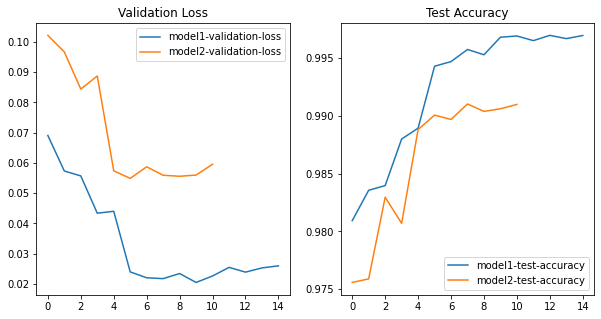

In [ ]:
#Evaluate the two models by using two metrics, loss and accuracy.
metrics = ['val_loss', 'accuracy']
#show the evaluation result by using matoplot.
plt.figure(figsize=(10, 5))
#Use "For Loop".
for i in range(len(metrics)):
    metric = metrics[i]
    #set subplots to show the result
    plt.subplot(1, 2, i+1)
    #Titles of subplots are "loss" and "accuracy"
    #plt.title(metric) 
  
    if(i == 0):
      plt.title('Validation Loss')
      #plt_test1_loss = history1.history['val_loss']
      #plt_test2_loss = history2.history['val_loss']
      plt_train1 = history1.history[metric] 
      plt_train2 = history2.history[metric]
      plt.plot(plt_train1, label='model1-validation-loss') 
      plt.plot(plt_train2, label='model2-validation-loss') 
    else:
      plt.title("Test Accuracy")
      plt_test1_acc = history1.history['val_accuracy']
      plt_test2_acc = history2.history['val_accuracy']
      plt.plot(plt_test1_acc, label='model1-test-accuracy') 
      plt.plot(plt_test2_acc, label='model2-test-accuracy') 
    
    #plt_test2 = Test2.history[metric] 
    #plot them all
    #plt.plot(plt_train1, label='model1-train') 
    #plt.plot(plt_train2, label='model2-train') 
    # plt.plot(plt_test1, label='model1-test') 
    # plt.plot(plt_test2, label='model2-test') 
    plt.legend() 
plt.show()

In [ ]:
!gdown --id 1uXWjYizXt75K0zx_QwT0U6m0W4GFK7Wo
!gdown --id 1d6Q5r6aOS2xh6TrIDV_5jP95ihLonuMO
!gdown --id 1gol1FUn8ub-1YT2oHZu5erahFlBxZf7E

Downloading...
From: https://drive.google.com/uc?id=1uXWjYizXt75K0zx_QwT0U6m0W4GFK7Wo
To: /content/model_hcr_2.h5
4.78MB [00:00, 18.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1d6Q5r6aOS2xh6TrIDV_5jP95ihLonuMO
To: /content/photo_2021-06-23_11-44-57.jpg
100% 32.3k/32.3k [00:00<00:00, 4.69MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gol1FUn8ub-1YT2oHZu5erahFlBxZf7E
To: /content/model_hcr_1.h5
100% 1.71M/1.71M [00:00<00:00, 26.1MB/s]


In [ ]:
# Displaying some of the test images & their predicted labels...
model1 = keras.models.load_model('/content/model_hcr_1.h5')
model2 = keras.models.load_model('/content/model_hcr_2.h5')

(74490, 28, 28, 1)
The answer is U .


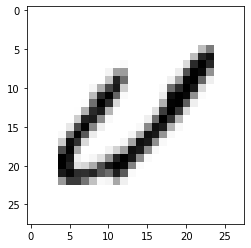

In [18]:
#Here is the prediction sample.
plt.imshow(test_X[[19]].reshape(28,28),cmap='Greys')

#Making model predictions...

pred = model1.predict(test_X[[19]])
print(test_X.shape)

#Preparation for this predction. 
alphabets="ABCDEFGHIJKLMNOPQRSTUVWXYZ"
list1=[]
[list1.append(i) for i in range(26)]
list2=[]
[list2.append(i) for i in alphabets]
dic = dict(zip(list1, list2))
#Let's check the result.
print("The answer is",dic[np.argmax(pred)],".")


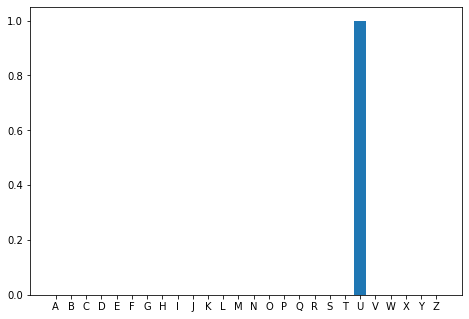

In [19]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
alphs = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
ax.bar(alphs,pred.flatten())
plt.show()

In [ ]:
print(pred.flatten())

[1.8969437e-20 1.0954652e-13 6.4462810e-08 1.7042558e-10 3.1908687e-14
 4.6577756e-17 4.3718038e-10 3.1769118e-15 3.0476216e-12 8.3790319e-06
 2.4830411e-15 4.5497985e-14 1.1338306e-15 2.2236304e-13 2.6786151e-10
 6.3519134e-11 3.5600461e-17 7.6180125e-25 2.6186495e-08 9.9999154e-01
 1.2835238e-09 4.9119781e-17 8.3402920e-12 1.7793169e-20 3.7303423e-09
 9.8440752e-12]


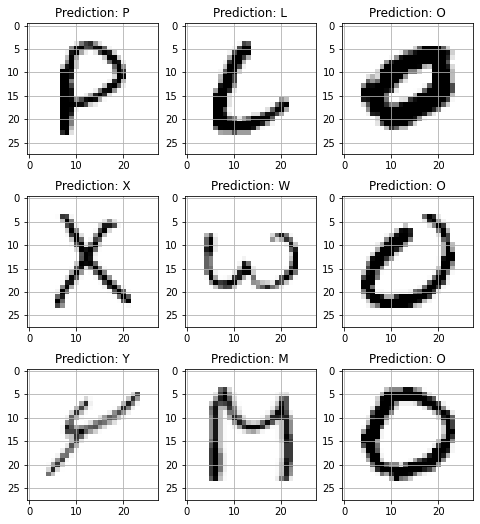

In [20]:
fig, axes = plt.subplots(3,3, figsize=(8,9))
axes = axes.flatten()
for i,ax in enumerate(axes):
    # img = np.reshape(test_X[i], (28,28))
    ax.imshow(test_X[[i]].reshape(28,28), cmap="Greys")

    pred = word_dict[np.argmax(model1.predict(test_X[[i]]))]
    ax.set_title("Prediction: "+pred)
    ax.grid()

## Prediction on External Images

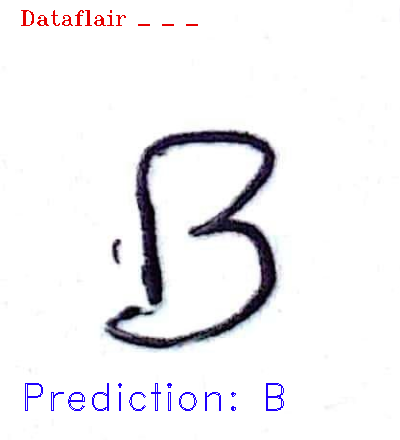

KeyboardInterrupt: ignored

In [21]:
from google.colab.patches import cv2_imshow
# Prediction on external image...

img = cv2.imread('/content/photo_2021-06-23_11-44-57.jpg')
img_copy = img.copy()

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (400,440))

img_copy = cv2.GaussianBlur(img_copy, (7,7), 0)
img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
_, img_thresh = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)

img_final = cv2.resize(img_thresh, (28,28))
img_final =np.reshape(img_final, (1,28,28,1))


img_pred = word_dict[np.argmax(model1.predict(img_final))]

cv2.putText(img, "Dataflair _ _ _ ", (20,25), cv2.FONT_HERSHEY_TRIPLEX, 0.7, color = (0,0,230))
cv2.putText(img, "Prediction: " + img_pred, (20,410), cv2.FONT_HERSHEY_DUPLEX, 1.3, color = (255,0,30))
cv2_imshow(img)


while (1):
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
cv2.destroyAllWindows()

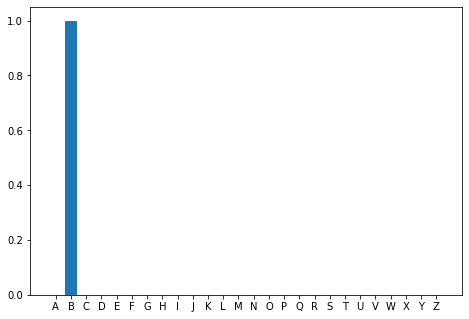

In [23]:
img = cv2.imread('/content/photo_2021-06-23_11-44-57.jpg')
img_copy = img.copy()

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (400,440))

img_copy = cv2.GaussianBlur(img_copy, (7,7), 0)
img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
_, img_thresh = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)

img_final = cv2.resize(img_thresh, (28,28))
img_final =np.reshape(img_final, (1,28,28,1))


pred = model1.predict(img_final)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
alphs = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
ax.bar(alphs,pred.flatten())
plt.show()